In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
# Create a MirroredStrateg, If Multi-GPU available
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
tf.config.set_soft_device_placement(True)
# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2']) 
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from livelossplot.keras import PlotLossesCallback
from livelossplot import PlotLossesKerasTF
from tqdm import tqdm
import efficientnet.keras as efn
import h5py, glob, re, cv2, math, matplotlib, pickle, gc
import tensorflow.keras as keras
import pandas as pd
from pandas import read_csv
import numpy as np
from scipy import stats
import itertools, random
from collections import Counter
# from cnn_utils import *
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from PIL import Image  
import pdb
from statistics import mode 
from IPython.display import clear_output

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

np.random.seed(1)
# Setting the seed for python random numbers
random.seed(1254)
# Setting the graph-level random seed.
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
!CUDA_VISIBLE_DEVICES=2

# strategy = tf.distribute.MirroredStrategy(devices=['/gpu:1','/gpu:2'])
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# print('Number of GPUs being used: {}'.format(strategy.num_replicas_in_sync))
# def setup_multi_node_training(): # IMPORTANT: SET UP TF_CONFIG FOR MULTINODE TRAINING HERE os.environ[“TF_FORCE_GPU_ALLOW_GROWTH”] = “true” tf.config.set_soft_device_placement(True) mirrored_strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(tf.distribute.experimental.CollectiveCommunication.NCCL) # Constructs the configuration run_config = tf.estimator.RunConfig( train_distribute=mirrored_strategy, ) return run_config
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using TensorFlow backend.


Num GPUs Available:  1


## Load data

In [2]:
filename = 'Datasets/final_imit_spec2.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_train_images, imit_test_images, imit_y_train, imit_y_test, imit_env_train, imit_env_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_train_images.shape)
print(imit_test_images.shape)
print(imit_y_train.shape)
print(imit_y_test.shape)
print(imit_env_train.shape)
print(imit_env_test.shape)

(1056,)
(264,)
(1056, 1482)
(264, 1482)
(1056,)
(264,)


In [9]:
print(imit_train_images[0].shape)

(813, 1482, 3)


##### STA LTA

In [3]:
def sta_lta2(vec,nlta,nsta,init_th,stop_th,stepsz):
    vec2 = np.zeros(vec.shape)
    mask = np.zeros(vec.shape)
    state = 0 # '0' nothing, '1' signing
    
    for i in range(0,len(vec),stepsz):
        
        if i+nlta+nsta+1 > len(vec):
            if state == 1:
                stoppt = len(vec)-2
                vec2[startpt:stoppt] = vec[startpt:stoppt]
                mask[startpt:stoppt] = 1
            break
            
            
        longwin = vec[i:i+nlta]
        shortwin = vec[i+nlta:i+nlta+nsta]
        
        if i < nlta and np.mean(longwin) > 150:
            vec2[0:i+nsta] = vec[0:i+nsta]
            mask[0:i+nsta] = 1
        if init_th < sum(shortwin)/sum(longwin):
            if state == 0:
                startpt = i+nlta
                state = 1
            if state == 1:
                continue
        
        else:
            if state == 0:
                continue
            if state == 1:
                if sum(shortwin)/sum(longwin) > stop_th:
                    continue
                else:
                    stoppt = i+nlta+int(nsta/2)
                    state = 0
                    vec2[startpt:stoppt] = vec[startpt:stoppt]
                    mask[startpt:stoppt] = 1
                    
    return vec2, mask

In [14]:
duration = 24.2
nsta_sec = 0.7
ratio = imit_env_train[0].shape[-1]/duration
nsta = int(nsta_sec*ratio)
nlta = int(2*nsta)
stepsz = int(0.2*ratio) # 0.2
timevec = np.linspace(0,24.2,imit_env_train[0].shape[-1])
idx = 27
init_th = 0.6
stop_th = 0.3
vecs_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
mask_train = [] #np.zeros(np.argmax(margin_tr,-1).shape)
vecs_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
mask_test = [] #np.zeros(np.argmax(margin_ts,-1).shape)
for i in range(len(imit_env_train)):
    vecs_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_train.append(sta_lta2(imit_env_train[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_train_win = mask_train[:,::5]
for i in range(len(imit_env_test)):
    vecs_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[0])
    mask_test.append(sta_lta2(imit_env_test[i],nlta,nsta,init_th,stop_th,stepsz)[1])
# mask_test_win = mask_test[:,::5]
mask_train = np.array(mask_train)
mask_test = np.array(mask_test)
print(mask_train.shape)
print(mask_test.shape)

(1056,)
(264,)


### Visualize

In [5]:
# idx = 3
# plt.plot(timevec,imit_env_test[idx]/max(imit_env_test[idx]),color='black')
# plt.plot(timevec,mask_test[idx],linewidth=3,color='red')
# plt.legend(['Euclidean Distance','STA/LTA Detector'], loc = 'upper right', fontsize = 'xx-large')
# fig = plt.gcf()
# fig.set_size_inches(12,6)
# plt.xticks(fontsize=19)
# plt.yticks(fontsize=19)
# plt.xlabel('Time (sec)',fontsize=19, fontname='Comic Sans MS')
# plt.ylabel('Normalized Euclidean Distance',fontsize=19)
# # plt.savefig(str(idx)+' gesture detect.png',dpi=400)

In [6]:
def gesture_counter(mask):
    cnt = 0
    flag = 0
    for i in range(len(mask)):
        if flag == 0 and mask[i] == 0:
            continue
        if flag == 1 and mask[i] == 1:
            continue
        if flag == 0 and mask[i] == 1:
            flag = 1
            cnt += 1
        if flag == 1 and mask[i] == 0:
            flag = 0
    return cnt

In [7]:
numgest = [gesture_counter(m) for m in mask_test]
sum(numgest)

1673

In [8]:
num_class = 19

In [15]:
def masker(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    for i in range(len(mask)):
        for j in range(mask[i].shape[0]):
            if flag == 0 and mask[i][j] == 0:
                continue
            if flag == 1 and mask[i][j] == 1:
                if j == mask[i].shape[0]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(cv2.resize(x[i][:,startpt:stoppt,:], (128, 128), interpolation = cv2.INTER_AREA))
                    y2.append(y[i,startpt:stoppt])
                else:
                    continue
            if flag == 0 and mask[i][j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i][j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(cv2.resize(x[i][:,startpt:stoppt,:], (128, 128), interpolation = cv2.INTER_AREA))
                    y2.append(y[i,startpt:stoppt])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [16]:
def down_mask(mask, des_len):
    return np.array([mask[int(len(mask)/des_len*i)] for i in range(des_len)])

In [17]:
# des_len = imit_train_images.shape[1]
# mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
# mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
# y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train])
# y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test])
# y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
# y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
# print(mask_down_train.shape)
# print(mask_down_test.shape)
# print(y_down_train.shape)
# print(y_down_test.shape)
# print(y_down_train_cat.shape)
# print(y_down_test_cat.shape)

In [54]:
x3train, y3train = masker(imit_train_images, imit_y_train, mask_train)
x3test, y3test = masker(imit_test_images, imit_y_test, mask_test) 
print(x3train.shape)
print(y3train.shape)
print(x3test.shape)
print(y3test.shape)

(6732, 128, 128, 3)
(6732,)
(1673, 128, 128, 3)
(1673,)


In [61]:
classes = [stats.mode(np.argmax(y,-1))[0] for y in y3train]
c = [int(x) for x in classes]
Counter(c)

Counter({1: 1778,
         2: 597,
         0: 467,
         3: 992,
         16: 194,
         17: 190,
         18: 208,
         13: 198,
         14: 213,
         15: 238,
         4: 198,
         5: 158,
         6: 161,
         10: 200,
         11: 178,
         12: 182,
         7: 181,
         8: 201,
         9: 198})

In [59]:
# eliminate zeros md
x6train = np.array([x3train[i] for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y6train = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3train[i],-1))[0],19)) for i in tqdm(range(len(y3train)), position = 0, leave = True) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x6test = np.array([x3test[i] for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y6test = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y3test[i],-1))[0],19)) for i in tqdm(range(len(y3test)), position = 0, leave = True) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x6train.shape)
print(y6train.shape)
print(x6test.shape)
print(y6test.shape)

100%|██████████| 1673/1673 [00:00<00:00, 2944.23it/s]

(6265, 128, 128, 3)
(6265, 19)
(1550, 128, 128, 3)
(1550, 19)


## RD - RA

In [21]:
filename = 'Datasets/final_imit_RD-RA2.pkl'
with open(filename, 'rb') as input:
    x = pickle.load(input)
imit_y_train_RD, imit_y_test_RD, imit_RD_train, imit_RA_train, imit_RD_test, imit_RA_test = [x[0], x[1]
                                                                                                , x[2], x[3]
                                                                                                , x[4], x[5]]
print(imit_y_train_RD.shape)
print(imit_y_test_RD.shape)
print(imit_RD_train.shape)
print(imit_RA_train.shape)
print(imit_RD_test.shape)
print(imit_RA_test.shape)
del x

(1056, 605)
(264, 605)
(1056, 605, 64, 64, 3)
(1056, 605, 64, 64, 3)
(264, 605, 64, 64, 3)
(264, 605, 64, 64, 3)


In [23]:
des_len = imit_y_train_RD.shape[1]
mask_down_train = np.array([down_mask(mask, des_len) for mask in mask_train])
mask_down_test = np.array([down_mask(mask, des_len) for mask in mask_test])
y_down_train = np.array([down_mask(y, des_len) for y in imit_y_train_RD])
y_down_test = np.array([down_mask(y, des_len) for y in imit_y_test_RD])
y_down_train_cat = to_categorical(y_down_train, num_classes=num_class)
y_down_test_cat = to_categorical(y_down_test, num_classes=num_class)
print(mask_down_train.shape)
print(mask_down_test.shape)
print(y_down_train.shape)
print(y_down_test.shape)
print(y_down_train_cat.shape)
print(y_down_test_cat.shape)

(1056, 605)
(264, 605)
(1056, 605)
(264, 605)
(1056, 605, 19)
(264, 605, 19)


In [26]:
# # windowed RD
# interval = range(0,600)
# x_train11 = np.reshape(imit_RD_train[:,interval,:,:,:], (imit_RD_train.shape[0],120,5,imit_RD_train.shape[2],imit_RD_train.shape[3],imit_RD_train.shape[4]))
# x_test11 = np.reshape(imit_RD_test[:,interval,:,:,:], (imit_RD_test.shape[0],120,5,imit_RD_test.shape[2],imit_RD_test.shape[3],imit_RD_test.shape[4]))
# y_train11 = np.reshape(imit_y_train_RD[:,interval], (imit_y_train_RD.shape[0],120,5))
# y_test11 = np.reshape(imit_y_test_RD[:,interval], (imit_y_test_RD.shape[0],120,5))
# y_train11 = to_categorical(np.squeeze(stats.mode(y_train11,2)[0]))
# y_test11 = to_categorical(np.squeeze(stats.mode(y_test11,2)[0]))
# print(x_train11.shape)
# print(y_train11.shape)
# print(x_test11.shape)
# print(y_test11.shape)  

# # windowed RA
# x_train12 = np.reshape(imit_RA_train[:,interval,:,:,:], (imit_RA_train.shape[0],120,5,imit_RA_train.shape[2],imit_RA_train.shape[3],imit_RA_train.shape[4]))
# x_test12 = np.reshape(imit_RA_test[:,interval,:,:,:], (imit_RA_test.shape[0],120,5,imit_RA_test.shape[2],imit_RA_test.shape[3],imit_RA_test.shape[4]))
# print(x_train12.shape)
# print(x_test12.shape)

(1056, 120, 5, 64, 64, 3)
(1056, 120, 19)
(264, 120, 5, 64, 64, 3)
(264, 120, 19)
(1056, 120, 5, 64, 64, 3)
(264, 120, 5, 64, 64, 3)


In [32]:
def masker_vid(x, y, mask):
    x2 = []
    y2 = []
    flag = 0
    
    for i in range(len(mask)):
        ratio = len(mask[i])/len(y[i])
        for j in range(mask[i].shape[0]):
            if flag == 0 and mask[i][j] == 0:
                continue
            if flag == 1 and mask[i][j] == 1:
                if j == mask[i].shape[0]-1 and j+1 - startpt > 2:
                    stoppt = j+1
                    x2.append(x[i,int(startpt//ratio):int(stoppt//ratio)])
                    y2.append(y[i,int(startpt//ratio):int(stoppt//ratio)])
                else:
                    continue
            if flag == 0 and mask[i][j] == 1:
                flag = 1
                startpt = j
            if flag == 1 and mask[i][j] == 0:
                flag = 0
                stoppt = j+1
                if stoppt-startpt > 2:
                    x2.append(x[i,int(startpt//ratio):int(stoppt//ratio)])
                    y2.append(y[i,int(startpt//ratio):int(stoppt//ratio)])
    
    x2 = np.asarray(x2)
    y2 = np.array([to_categorical(y,num_classes=num_class) for y in np.array(y2)])
    return x2, y2

In [35]:
x1train, y1train = masker_vid(imit_RD_train, imit_y_train_RD, mask_train)
x1test, y1test = masker_vid(imit_RD_test, imit_y_test_RD, mask_test)
x2train, y1train = masker_vid(imit_RA_train, imit_y_train_RD, mask_train)
x2test, y1test = masker_vid(imit_RA_test, imit_y_test_RD, mask_test)
print(x1train.shape)
print(y1train.shape)
print(x1test.shape)
print(y1test.shape)
print(x2train.shape)
print(x2test.shape)

(6732,)
(6732,)
(1673,)
(1673,)
(6732,)
(1673,)


In [36]:
y1train[0].shape

(116, 19)

In [88]:
x10train = np.array([x1train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x11train = np.array([x2train[i] for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
y10train = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y1train[i],-1))[0],19)) for i in range(len(y3train)) if stats.mode(np.argmax(y3train[i],-1))[0] != 0])
x10test = np.array([x1test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
x11test = np.array([x2test[i] for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
y10test = np.array([np.squeeze(to_categorical(stats.mode(np.argmax(y1test[i],-1))[0],19)) for i in range(len(y3test)) if stats.mode(np.argmax(y3test[i],-1))[0] != 0])
print(x10train.shape)
print(y10train.shape)
print(x10test.shape)
print(y10test.shape)
print(x11train.shape)
print(x11test.shape)

(6265,)
(6265, 19)
(1550,)
(1550, 19)
(6265,)
(1550,)


In [40]:
input_shape_vid = (None, x10train[0].shape[1],x10train[0].shape[2],x10train[0].shape[3])
print('Input shape of f-b-f RD: ',input_shape_vid)

Input shape of f-b-f RD:  (None, 64, 64, 3)


In [43]:
input_shape11 = (x3train[0].shape[0],x3train[0].shape[1],x3train[0].shape[2])
print('Input shape of f-b-f mD: ',input_shape11)

Input shape of f-b-f mD:  (128, 128, 3)


In [44]:
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)

In [45]:
gc.collect()

101

# Baseline

In [46]:
def data_generator(data, labels, batch_size=1):              
    """
    Yields the next training batch.
    data is an array  [[[frame1_filename,frame2_filename,…frame16_filename],label1], [[frame1_filename,frame2_filename,…frame16_filename],label2],……….].
    """
    num_samples = data.shape[0]
    
    while True:   
        for offset in range(0, num_samples, batch_size):
    #             print ('starting index: ', offset) 
            # Get the samples you'll use in this batch
            batch_samples = data[offset:offset+batch_size]
            label = labels[offset:offset+batch_size]
            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []
            # For each example
            for i in range(0,batch_samples.shape[0]):
                X_train.append(batch_samples[i])
                y_train.append(label[i])

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #X_train = np.rollaxis(X_train,1,4)
            y_train = np.array(y_train)

            # yield the next training batch            
            yield X_train, y_train

## mD

In [64]:
def cnn2_bilstm_seq(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputlayer1)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Reshape((-1,128))(x)
#         x = TimeDistributed(Flatten())(x)
        
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [65]:
model = cnn2_bilstm_seq(input_shape11)
# model.summary()

In [66]:
train_dataset = data_generator(x6train, y6train)
validation_dataset = data_generator(x6test, y6test)

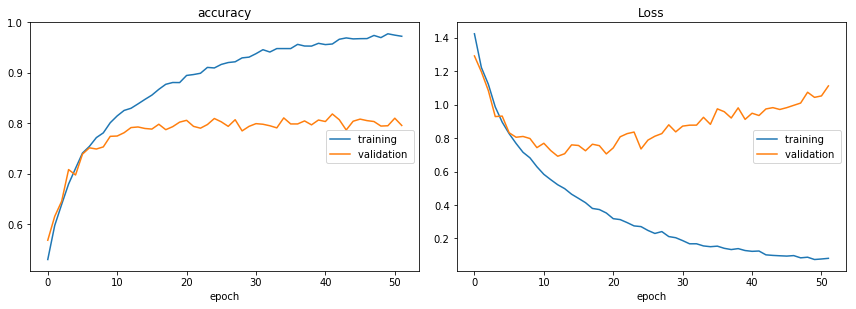

accuracy
	training         	 (min:    0.530, max:    0.977, cur:    0.972)
	validation       	 (min:    0.568, max:    0.818, cur:    0.796)
Loss
	training         	 (min:    0.074, max:    1.423, cur:    0.081)
	validation       	 (min:    0.691, max:    1.291, cur:    1.112)
6732/6732 [==============================] - 103s 15ms/step - loss: 0.0814 - accuracy: 0.9721 - val_loss: 1.1116 - val_accuracy: 0.7956


In [68]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x3train), validation_steps = len(x3test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [69]:
# save model
fname = 'final md td2d - 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [70]:
loss, acc = model.evaluate(validation_dataset, steps = len(x6test))
loss, acc

1550/1550 [==============================] - 10s 6ms/step - loss: 0.9687 - accuracy: 0.8129


(0.9686833620071411, 0.8129032254219055)

## RD

In [89]:
def cnn2_bilstm_seq_vid(input_shapex):
    with tf.device('/gpu:2'):
#     with strategy.scope():
        inputlayer1 = Input(shape = input_shapex)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(inputlayer1)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(2,2)))(x)
        x = Reshape((-1,8*8*8))(x)
#         x = TimeDistributed(Flatten())(x)
        
#         mask = Masking(mask_value=0.)(x)
        x = Bidirectional(LSTM(128, dropout=0.5, return_sequences=False))(x)
        
        out1 = Dense(num_class,activation='softmax')(x)
#         out1 = TimeDistributed(Dense(num_class,activation='softmax'))(x, mask=maskinput)
#         model = keras.Model(inputs = [inputlayer1,maskinput], outputs = [out1])#, out2, out3])
        model = keras.Model(inputs = [inputlayer1], outputs = [out1])#, out2, out3])
        opt = Adam(lr=1e-3, decay=1e-3 / 200)
        model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
        return model 

In [90]:
model = cnn2_bilstm_seq_vid(input_shape_vid)
# model.summary()

In [91]:
train_dataset = data_generator(x10train, y10train)
validation_dataset = data_generator(x10test, y10test)

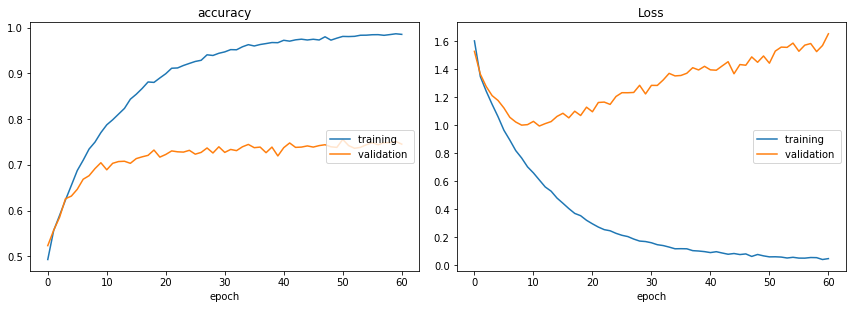

accuracy
	training         	 (min:    0.493, max:    0.986, cur:    0.985)
	validation       	 (min:    0.523, max:    0.818, cur:    0.745)
Loss
	training         	 (min:    0.041, max:    1.604, cur:    0.047)
	validation       	 (min:    0.691, max:    1.655, cur:    1.655)
6265/6265 [==============================] - 108s 17ms/step - loss: 0.0472 - accuracy: 0.9852 - val_loss: 1.6545 - val_accuracy: 0.7452


In [92]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    batch_size = 1,
    epochs=100,
    steps_per_epoch = len(x10train), validation_steps = len(x10test),
    callbacks=[early_stopping, PlotLossesKerasTF()],
    verbose = 1
)

In [69]:
# save model
fname = 'final rd td2d - 2'
MODEL_FILE = 'Models/' + fname + '.json' # save path
WEIGHT_FILE = 'Models/' + fname + '.h5' # save path

model_json = model.to_json()
with open(MODEL_FILE, "w") as json_file:
    json_file.write(model_json)
model.save_weights(WEIGHT_FILE)

In [93]:
loss, acc = model.evaluate(validation_dataset, steps = len(x10test))
loss, acc

1550/1550 [==============================] - 13s 8ms/step - loss: 1.4442 - accuracy: 0.7555


(1.444240689277649, 0.755483865737915)